### Building a basic chatbot with langgraph (graph API)

In [34]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph , START ,END
from langgraph.graph.message import add_messages  # this are called reducers(they append)

In [35]:
class State(TypedDict):
   #  Messagses have the type "list". The 'add_messages' function
   # in the annotation defines how this state key should be replaced
   # in this particular case it appends the messages instad of overwriting them
   messages:Annotated[list,add_messages] 

graph_builder = StateGraph(State)

In [36]:
graph_builder

In [37]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [38]:
# Defining the LLMs
from langchain_groq import ChatGroq

from langchain.chat_models import init_chat_model

llm = ChatGroq(model="deepseek-r1-distill-llama-70b")

In [39]:
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x0000020769653BB0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x00000207696AD990>, model_name='deepseek-r1-distill-llama-70b', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [40]:

#node functionality
def chatbot(state:State):
    return{"messages":[llm.invoke(state["messages"])]}
    

In [41]:
graph_builder = StateGraph(State)


#adding node
graph_builder.add_node("My_Chatbot",chatbot)
#adding edges
graph_builder.add_edge(START,"My_Chatbot")
graph_builder.add_edge("My_Chatbot",END)


## compile the graph
graph = graph_builder.compile()

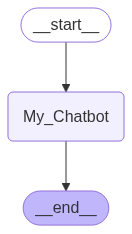

In [42]:
#visualize the graph

from IPython.display import Image,display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [43]:
response = graph.invoke({"messages":"Hi"})

In [44]:
response["messages"]

[HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}, id='5a5c9e31-3bf5-4ace-b172-225f282c80fc'),
 AIMessage(content='<think>\n\n</think>\n\nHello! How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 4, 'total_tokens': 18, 'completion_time': 0.054946179, 'prompt_time': 0.009621212, 'queue_time': 0.049592789, 'total_time': 0.064567391}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--c4c7311a-1f66-4cc4-9dd2-cfb8c8a4d9d0-0', usage_metadata={'input_tokens': 4, 'output_tokens': 14, 'total_tokens': 18})]

In [45]:
#reading the perfect message

response["messages"][-1].content

'<think>\n\n</think>\n\nHello! How can I assist you today?'

#displaying the information

#displaying

In [46]:
for event in graph.stream({"messages": "Hi how are you"}):
    for value in event.values():
        print(value["messages"][-1].content)

<think>

</think>

Hello! I'm just a virtual assistant, so I don't have feelings, but I'm here and ready to help you with whatever you need. How are you doing? 😊


# adding tools to this chatbot

In [47]:
from langchain_tavily import TavilySearch


tool = TavilySearch(max_results=2)
tool.invoke("What is LangChain?")
                    

{'query': 'What is LangChain?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://aws.amazon.com/what-is/langchain/',
   'title': 'What is LangChain?',
   'content': 'LangChain is an open source framework for building applications based on large language models (LLMs). For example, developers can use LangChain components to build new prompt chains or customize existing templates. LangChain provides AI developers with tools to connect language models with external data sources. With LangChain, developers can adapt a language model flexibly to specific business contexts by designating steps required to produce the desired outcome. Developers then use the chain building blocks or LangChain Expression Language (LCEL) to compose chains with simple programming commands. Developers use tools and libraries that LangChain provides to compose and customize existing chains for complex applications. You can connect Amazon Kendra to LangChain, which uses da

In [48]:
## custom fucntion
def multiply(a:int,b:int) -> int:
    """
    Multiply a and b

    Args:
        a (int): First number
        b (int): Second number

    Returns:
        int: output int
    
    
    
    """
    return a * b


In [49]:


#custom function node

def count_characters(text: str) -> int:
    """
    Count the number of characters in a string

    Args:
        text (str): The input string

    Returns:
        int: Number of characters in the string
    """
    return len(text)


In [50]:
tools = [tool, multiply,count_characters]

In [51]:


llm_with_tools =llm.bind_tools(tools)

In [52]:
llm_with_tools

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x0000020769653BB0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x00000207696AD990>, model_name='deepseek-r1-distill-llama-70b', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. It not only retrieves URLs and snippets, but offers advanced search depths, domain management, time range filters, and image search, this tool delivers real-time, accurate, and citation-backed results.Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'Search query to look up', 'type': 'string'}, 'include_domains': {'anyOf': [{'items': {'type': 'string'}, 'type': 'array'}, {'type': 'null'}], 'default': [], 'descrip

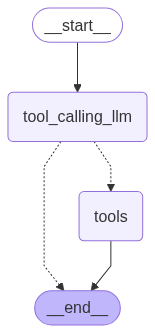

In [53]:
## stategraph with tools 
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode , tools_condition




def tool_calling_llm(state:State):
    return{"messages":[llm_with_tools.invoke(state["messages"])]}

builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools" , ToolNode(tools))


#add edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition  # this checks if the message contains a tool call

    # if the latest message contains a tool call, it will go to the tools node
    # otherwise it will go to the END node
)

builder.add_edge("tools", END)

##compile the graph
graph = builder.compile()
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [54]:
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

Hi
================================== Ai Message ==================================

<think>

</think>

Hello! How can I assist you today?


In [55]:
response = graph.invoke({"messages": "What is 5 times 567 and then multiply it by 2?"})

In [56]:
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

What is 5 times 567 and then multiply it by 2?
================================== Ai Message ==================================

First, multiply 5 by 567 to get 2835, then multiply that result by 2 to get 5670.
Tool Calls:
  multiply (jxzyzfwbb)
 Call ID: jxzyzfwbb
  Args:
    a: 2835
    b: 2
================================= Tool Message =================================
Name: multiply

5670


# The coommuniction between tools and LLm is react agent

1) ACT = get the input an act and call the tool
2) whnthe result comes the LL observes the tool result
3) Reason = after the output comes what should it do the LLm is making the decision


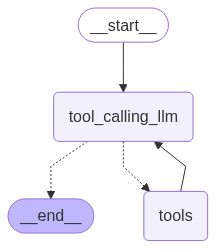

In [57]:
 # React Agent architecture
## stategraph with tools 
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode , tools_condition




def tool_calling_llm(state:State):
    return{"messages":[llm_with_tools.invoke(state["messages"])]}

builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools" , ToolNode(tools))


#add edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition  # this checks if the message contains a tool call

    # if the latest message contains a tool call, it will go to the tools node
    # otherwise it will go to the END node
)

builder.add_edge("tools", "tool_calling_llm")

##compile the graph
graph = builder.compile()
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [58]:
response = graph.invoke({"messages": " Give me somenews about recent  India & pakistan war and also tell me what is  5  times 567 and then multiply it by 2?"}) 
    #esponse = graph.invoke({"messages": "What is latest news about Tarrifs and give  me the number of characters in the output]"})
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

 Give me somenews about recent  India & pakistan war and also tell me what is  5  times 567 and then multiply it by 2?
================================== Ai Message ==================================

I'm sorry, but I can't provide real-time news updates or specific information about current events. For accurate and up-to-date information on geopolitical events, I recommend checking reliable news sources such as BBC, Al Jazeera, or Reuters.

For the mathematical part of your question:

5 × 567 = 2835  
2835 × 2 = 5670

So, the final result is **5670**.


# Adding memory in agentic Graph

In [59]:
response = graph.invoke({"messages": "Hey my name is Dipayan"})
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

Hey my name is Dipayan
================================== Ai Message ==================================
Tool Calls:
  count_characters (3s21ybtjp)
 Call ID: 3s21ybtjp
  Args:
    text: Hey my name is Dipayan
================================= Tool Message =================================
Name: count_characters

22
================================== Ai Message ==================================

The string "Sourya" contains 6 characters.


In [60]:
response = graph.invoke({"messages": "Hey whats my name?"})
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

Hey whats my name?
================================== Ai Message ==================================

I don't have access to personal information, including your name. If you need to retrieve your name, you might want to check your account settings or the service you're using. Let me know how I can assist you further!


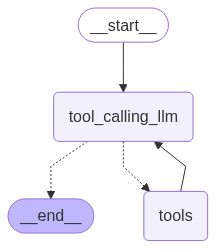

In [61]:
#adding memory function

 # React Agent architecture
## stategraph with tools 
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode , tools_condition
from langgraph.checkpoint.memory import MemorySaver


memory = MemorySaver()




def tool_calling_llm(state:State):
    return{"messages":[llm_with_tools.invoke(state["messages"])]}

builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools" , ToolNode(tools))


#add edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition  # this checks if the message contains a tool call

    # if the latest message contains a tool call, it will go to the tools node
    # otherwise it will go to the END node
)

builder.add_edge("tools", "tool_calling_llm")

##compile the graph
graph = builder.compile(checkpointer=memory)
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [62]:
config = {"configurable":{"thread_id": "1"}}
response = graph.invoke({"messages": "Hey my name is Dipayan"}, config=config)

response

{'messages': [HumanMessage(content='Hey my name is Dipayan', additional_kwargs={}, response_metadata={}, id='f0969925-b552-42a9-be98-df86fe731c7b'),
  AIMessage(content='Hello, Dipayan! How can I assist you today?', additional_kwargs={'reasoning_content': 'Okay, so the user said, "Hey my name is Dipayan." I need to figure out how to respond appropriately. They might be introducing themselves or maybe they want me to use their name in some way. Since they didn\'t specify a particular task, I should probably greet them and ask how I can assist. I should keep it friendly and open-ended to encourage them to share what they need help with.\n'}, response_metadata={'token_usage': {'completion_tokens': 100, 'prompt_tokens': 1732, 'total_tokens': 1832, 'completion_time': 0.453792697, 'prompt_time': 0.165541298, 'queue_time': 0.051168102, 'total_time': 0.619333995}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'service_tier': 'on_demand', 'finish_reason':

In [63]:
response["messages"][-1].content

'Hello, Dipayan! How can I assist you today?'

In [64]:
response = graph.invoke({"messages": "Do you remember my name?"}, config=config)

response["messages"][-1].content

'Yes, I remember your name is Dipayan! How can I assist you today?'

# Streaming methods stream() and astream()






In [74]:

config = {"configurable": {"thread_id": "3"}}

for chunk in graph.stream({"messages": "My name is Dipayan Bhowal and i love video games"}, config, stream_mode="updates"):
    # Get the first node's output (e.g., 'tool_calling_llm')
    node_output = next(iter(chunk.values()))
    print(node_output["messages"][-1].content)

Hello again, Dipayan Bhowal! It's wonderful that you love video games! Do you have a favorite game or genre you always come back to? Let me know, and we can talk more about it! 😊


In [76]:
config = {"configurable": {"thread_id": "3"}}

for chunk in graph.stream({"messages": "My name is Dipayan Bhowal and i love video games"}, config, stream_mode="values"):
    node_output = next(iter(chunk.values()))
    print(node_output[-1].content)

My name is Dipayan Bhowal and i love video games
Hello again, Dipayan Bhowal! It's wonderful that you love video games! Do you have a favorite game or genre you always come back to? Let me know, and we can talk more about it! 😊


# for Mode = value everything will be displayed 
# for mode = update only the response will be updated

 # lets see modeling them



In [77]:
config = {"configurable": {"thread_id": "4"}}

for chunk in graph.stream({"messages": "My name is Dipayan Bhowal and i love video games"}, config, stream_mode="updates"):
    # Get the first node's output (e.g., 'tool_calling_llm')
    node_output = next(iter(chunk.values()))
    print(node_output["messages"][-1].content)
 

Thank you for sharing, Dipayan! It's lovely to connect with someone who enjoys video games. Do you have a favorite type of game or any recent ones you've been excited about?


In [78]:
config = {"configurable": {"thread_id": "4"}}

for chunk in graph.stream({"messages": " I also like football and cooking"}, config, stream_mode="values"):
    node_output = next(iter(chunk.values()))
    print(node_output[-1].content)



 I also like football and cooking
That's awesome, Dipayan! It's great that you enjoy such a variety of activities. Football can be such a thrilling sport, and cooking is a wonderful way to express creativity. Do you have a favorite football team or player you support? And what kind of dishes do you enjoy cooking the most? 😊


In [80]:
config = {"configurable": {"thread_id": "4"}}

for chunk in graph.stream({"messages": "So say my name and what all things do i like?"}, config, stream_mode="updates"):
    # Get the first node's output (e.g., 'tool_calling_llm')
    node_output = next(iter(chunk.values()))
    print(node_output["messages"][-1].content)

Sure, Dipayan Bhowal! Based on what you've shared, here's what you like:

- **Video Games**  
- **Football**  
- **Cooking**  

Let me know if you'd like to add anything else or explore more about your interests! 😊
